In [1]:
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset,OutputVis
import os
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
plt.style.use('ybpres.mplstyle')
import pandas as pd

In [2]:
dataset_name = "dfCERA_long"
DatasetCatalog.register(dataset_name, grab_dataset(dataset_name))
MetadataCatalog.get(dataset_name).thing_classes = [""]
vis =OutputVis(dataset_name,pred_mode='file',pred_file = 'output_dfCERA_long/coco_instances_results.json',has_annotations=False)


In [3]:
dfpts = pd.read_csv('/data/amd-data/cera-rpd/detectron2-rpd/output_dfCERA_long/dfpts.csv')[['volID','dt_instances']]
dfimg = pd.read_csv('/data/amd-data/cera-rpd/detectron2-rpd/output_dfCERA_long/dfimg.csv',index_col=0)[['volID','scan']].reset_index()
dfdata = pd.read_parquet('/data/amd-data/cera-rpd/detectron2-rpd/datasets/dfCERA_long.parquet')
dfdata = dfdata[dfdata.fold=='CERA_long'][['ptid','eye','time','volID','slicei']]
dfinstances = dfdata[['ptid','eye','time','volID']].drop_duplicates().merge(dfpts,on='volID')
dfdata = dfimg.merge(dfdata,left_on=['volID','scan'],right_on=['volID','slicei']).set_index('index').drop(columns=['slicei'])

Check overlap with training set

In [23]:
def checkSplit2(df):
    """Check for overlap across folds in df.

    Args:
        df (pd.DataFrame): specifies fold for each image. 

    Returns:
        dffolds (pd.DataFrame): A dataframe equivalent of the intersection matrix of folds.
    """
    dfsets = df.groupby('fold')['ptid'].apply(lambda x :set(x))
    splitdict = {}
    dffolds = pd.DataFrame(index = dfsets.index,columns=dfsets.index)
    for key,value in dfsets.items():
        for key2,value2 in dfsets.items():
            dffolds.loc[key,key2]= (len(set.intersection(value,value2)))
    return dffolds


dflist = []
for i in range(1,6):
    dflist.append(pd.read_csv(f'output_valid_fold{i}/results/dfimg_fold{i}.csv').assign(fold=f'fold{i}').replace({'eye': {'OS':'L', 'OD':'R'}}))

dflist.append(pd.read_csv(f'output_valid_test/results/dfimg_test.csv').assign(fold='test').replace({'eye': {'OS':'L', 'OD':'R'}}))
dflist.append(pd.read_csv(f'output_ext_test/dfimg_ext_test.csv').assign(fold='test').replace({'eye': {'OS':'L', 'OD':'R'}}))
checkSplit2(pd.concat(dflist+[dfinstances.assign(fold='long')]))

fold  fold1 fold2 fold3 fold4 fold5 long test
fold                                         
fold1    20     0     0     0     0    0    0
fold2     0    20     0     0     0    0    0
fold3     0     0    20     0     0    0    0
fold4     0     0     0    20     0    0    0
fold5     0     0     0     0    20    0    0
long      0     0     0     0     0   94    0
test      0     0     0     0     0    0   21

Limit to ptids in the sham group

In [4]:
ptids = pd.read_csv('datasets/CERA_sham_ptids.txt',names = ['ptid'],dtype='str').ptid
dfinstances = dfinstances[dfinstances.ptid.isin(ptids)]

Limit to ptids with more than x instances:

In [8]:
ptids = dfinstances[dfinstances['dt_instances']>10].ptid.drop_duplicates()
dfinstances = dfinstances[dfinstances.ptid.isin(ptids)]

Drop 101082 month 24 --wrong volume.

In [5]:
dfinstances = dfinstances[(dfinstances['volID']!='101082_R_24')&(dfinstances['volID']!='101082_L_24')]

In [9]:
dfinstances.nunique()

ptid             50
eye               2
time              7
volID           656
dt_instances    210
dtype: int64

Define eye groups and label by mean RPD over time.

In [62]:
eye_groups = dfinstances.sort_values(['ptid','eye','time']).groupby(['ptid','eye'])
inst_means = eye_groups['dt_instances'].mean().to_frame()
dfinstances = dfinstances.merge(pd.cut(inst_means['dt_instances'], list(range(0,20,5))+list(range(20,160,10))+list(range(160,230,30))+list(range(230,420,60))),on=['ptid','eye'],suffixes=['','_grp'])
dfinstances.loc[:,'dt_instances_grp'] = dfinstances.dt_instances_grp.astype('object') #this is to plot only since grouping by categorical type honors empty groups and we don't want that

Plot trendlines for each group

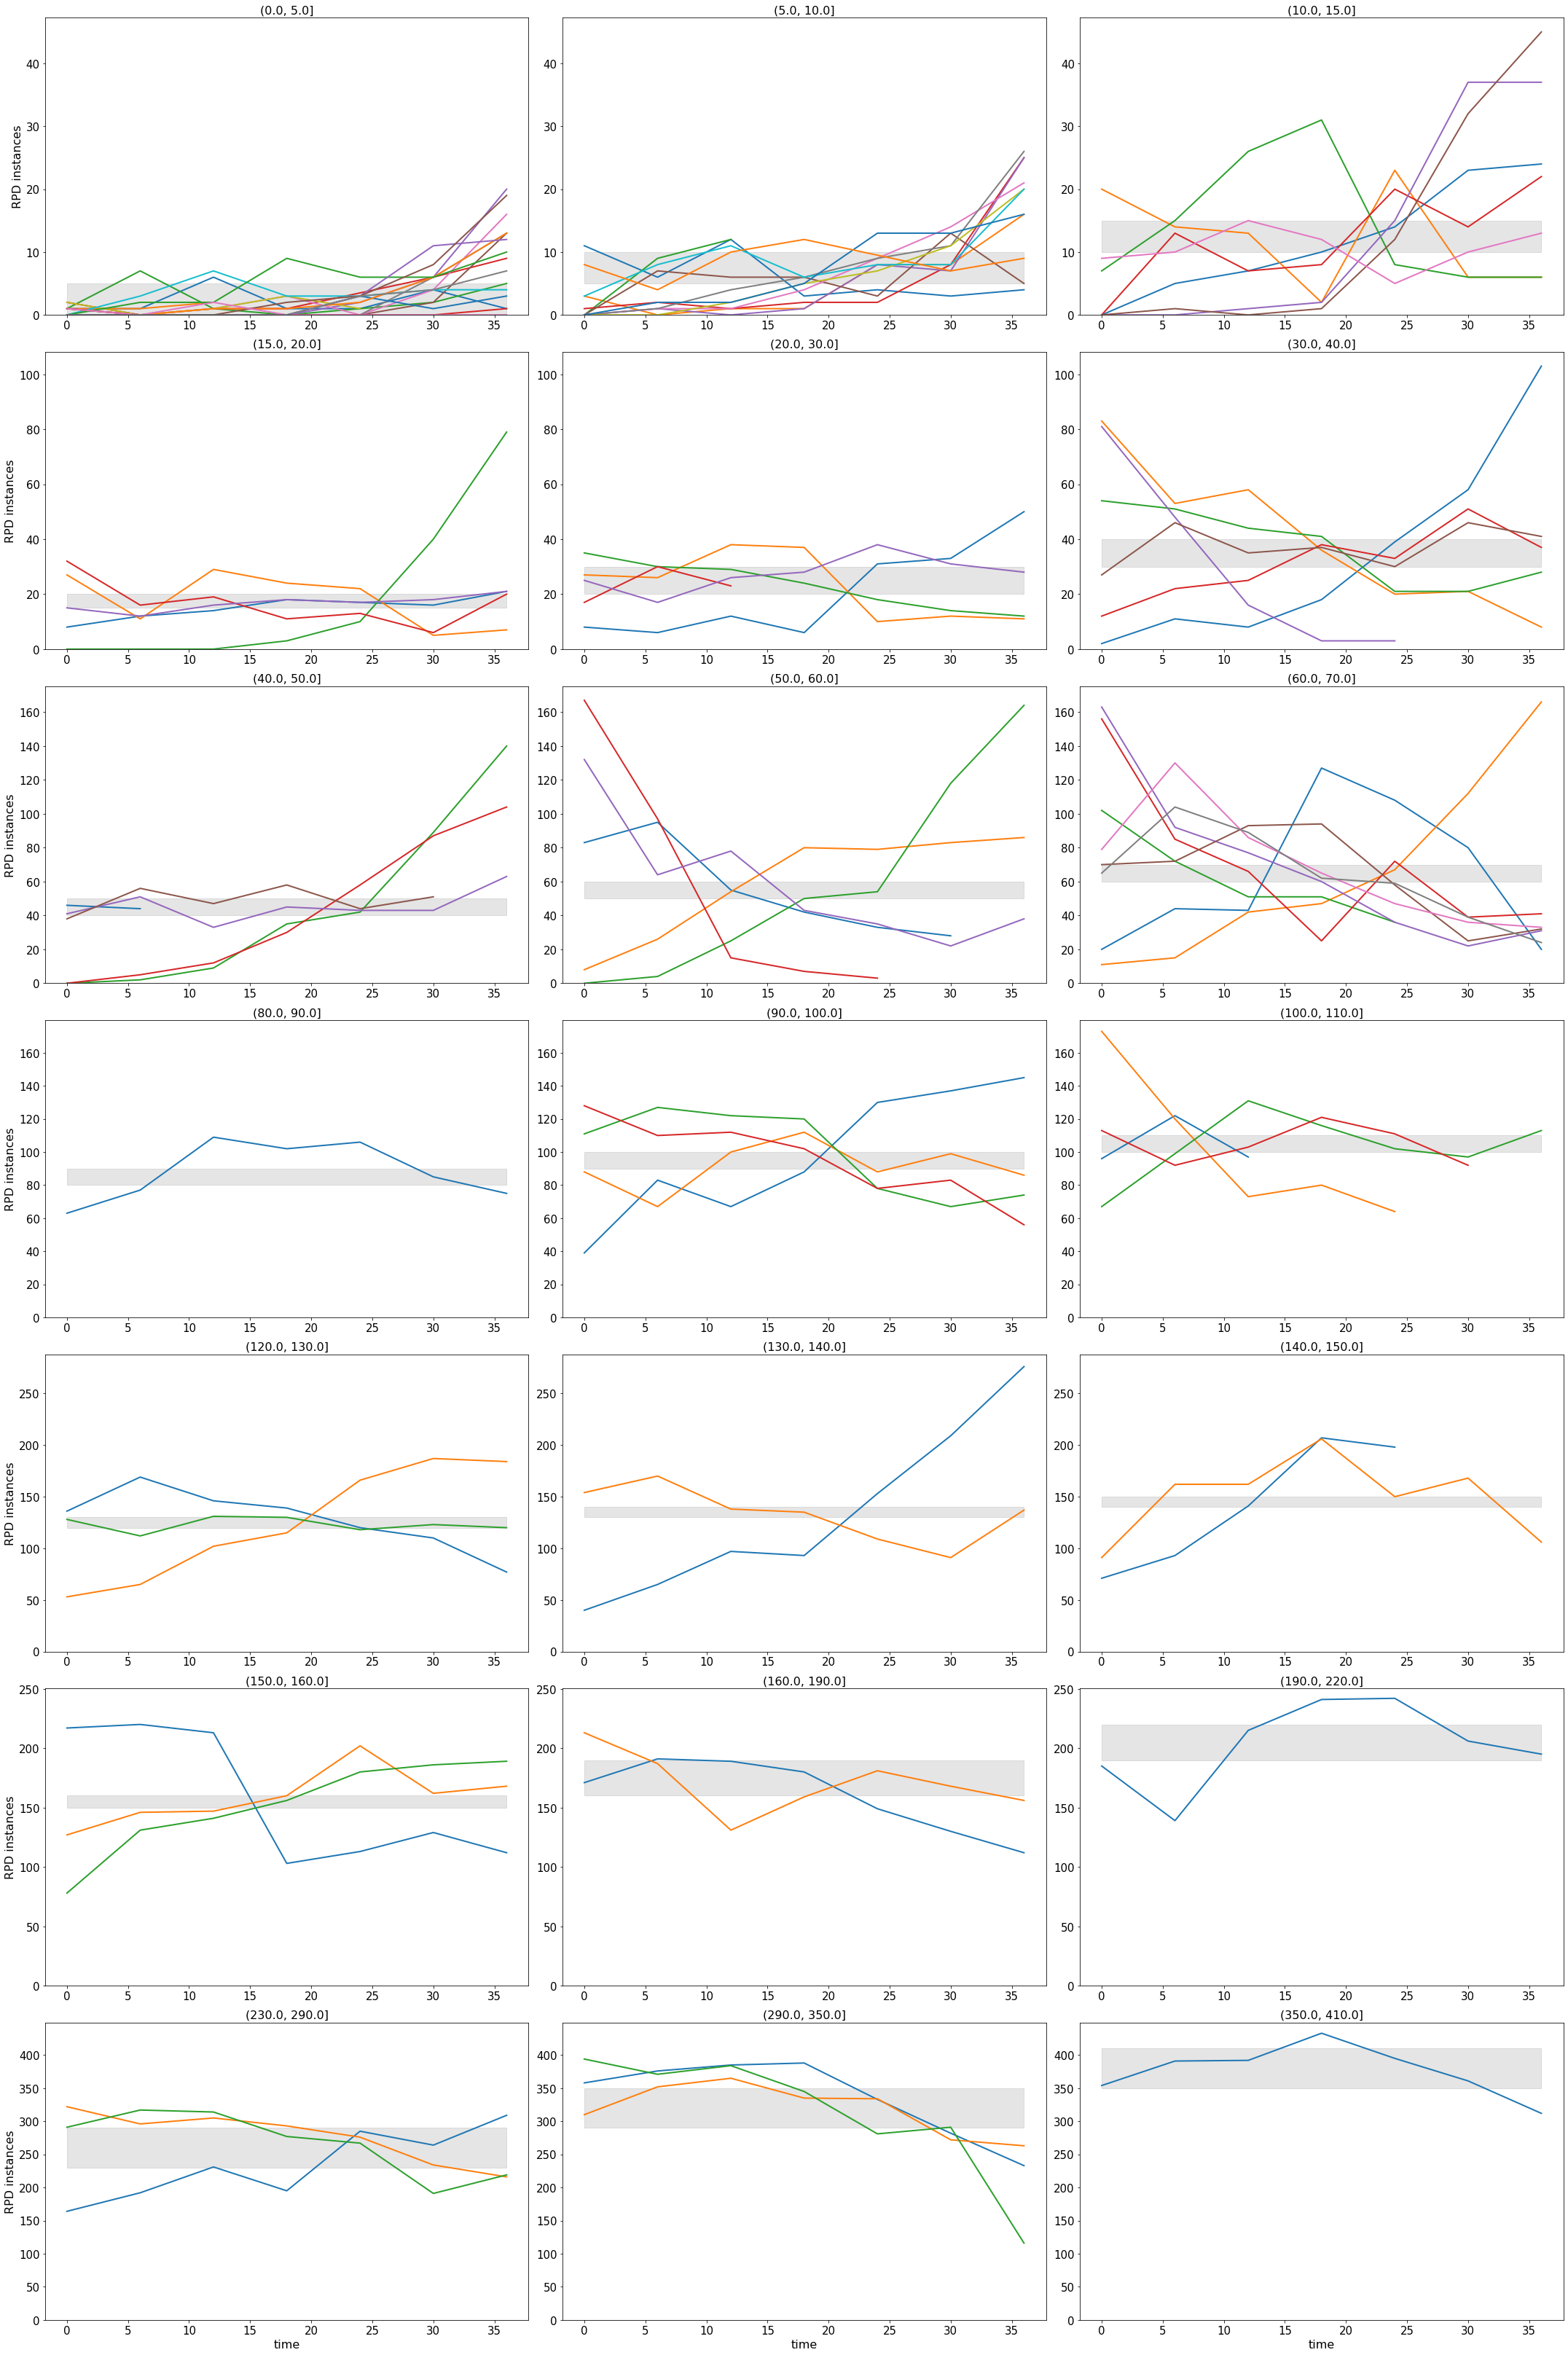

In [63]:

grps = dfinstances.sort_values(by='dt_instances_grp').groupby(['dt_instances_grp'])
fig,axs = plt.subplots(7,3,figsize=[30,45],sharex=True,sharey='row')
maxt = dfinstances.time.max()
for ax, (name,grp) in zip (fig.axes, grps): #for each interval
        grp.sort_values(['ptid','eye','time']).groupby(['ptid','eye']).plot(x='time',y='dt_instances',ax=ax,legend=False,ylabel='RPD instances') #group by eye and plot
        ax.set_title(name)
        ax.fill_between([0,maxt],name.left,name.right,alpha=.10,color='k')
for ax in fig.axes:
        ax.xaxis.set_tick_params(labelbottom=True)
        ax.yaxis.set_tick_params(labelleft=True)
plt.setp(axs,ylim=(0,None))
plt.tight_layout()

In [117]:
fig.savefig('output_dfCERA_long/longitudinal_plots.png',dpi=120)

### Visual inspection

ptid    eye
101041  R      AxesSubplot(0.125,0.125;0.775x0.755)
101110  L      AxesSubplot(0.125,0.125;0.775x0.755)
101291  L      AxesSubplot(0.125,0.125;0.775x0.755)
Name: dt_instances, dtype: object

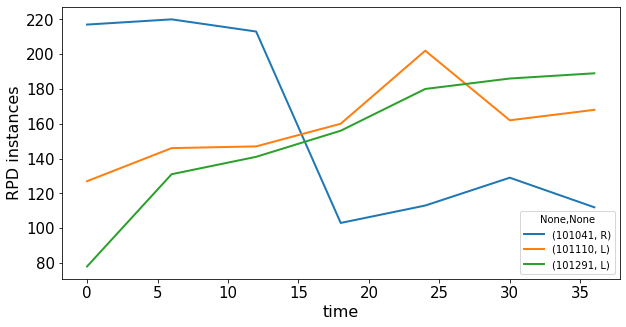

In [85]:
plt.figure(figsize=[10,5])
grp = grps.get_group(pd.Interval(150.0,160.0,closed='right'))
grp.sort_values(['ptid','eye','time']).set_index('time').groupby(['ptid','eye'],)['dt_instances'].plot(legend=True,ylabel='RPD instances') #group by eye and plot


Enface predictions for eye over time

In [86]:
# ptid = '101142'
# eye = 'L'

# ptid = '101082' #erronous volume at 24 months
# # eye = 'R'
# eye = 'L'

# ptid = '101227' #decrease to zero from 80
# eye = 'R'

ptid = '101041'
# eye = 'L'
eye = 'R'


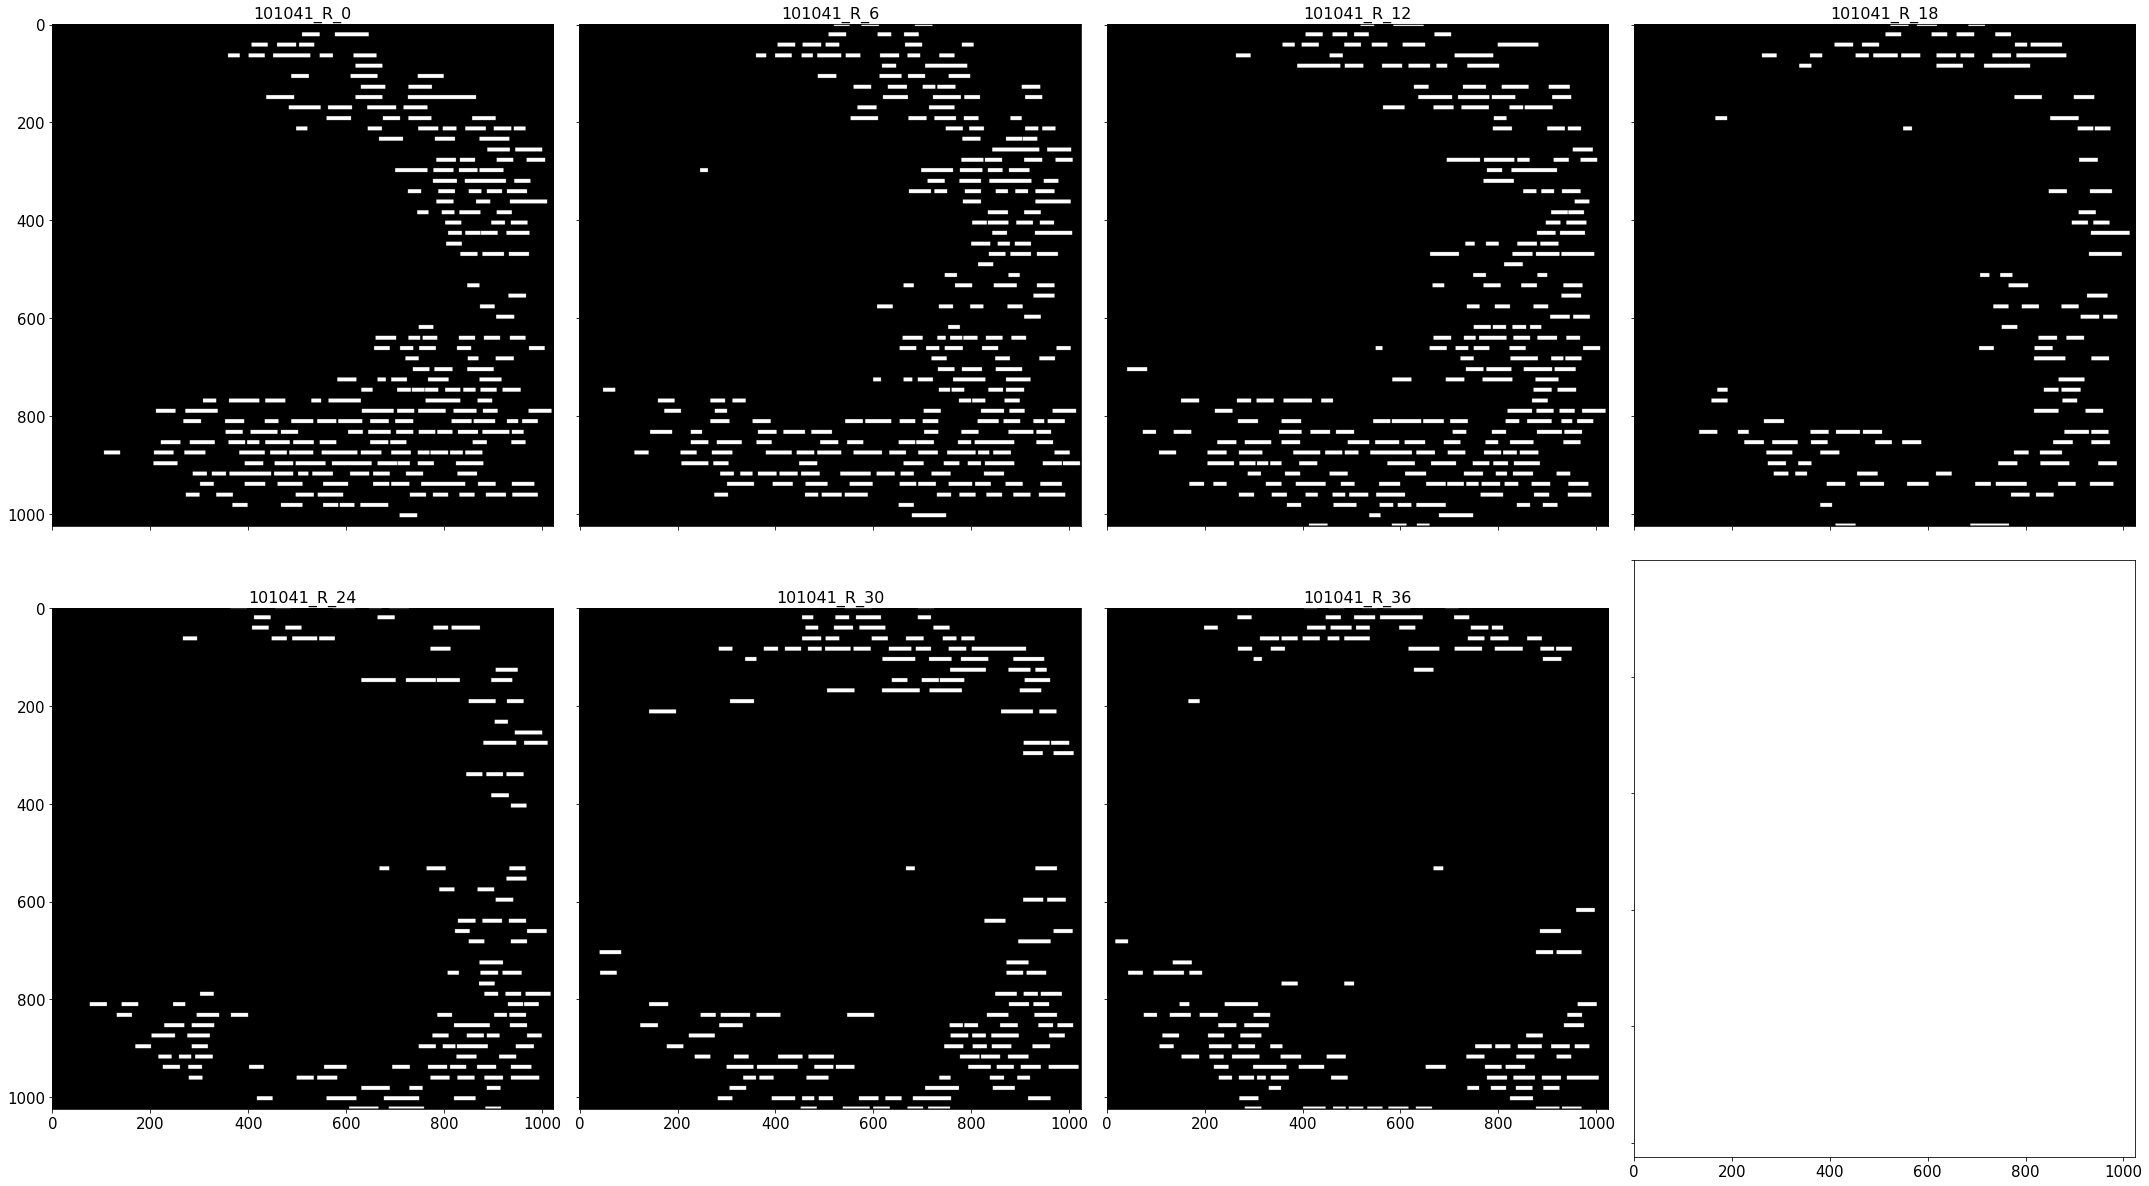

In [87]:
%matplotlib inline
fig,axs = plt.subplots(2,4,figsize=[30,17],sharex=True,sharey=True)
#fig.delaxes(fig.axes[-1]) #deletes the last set of unused axes (optional)
for volid,ax in zip(eye_groups.get_group((ptid,eye)).volID,fig.axes):
    im = vis.get_enface_dt(dfimg[dfimg.volID==volid].set_index('index'),496,1024,1024/48)
    ax.imshow(im)
    ax.set_title(volid)
plt.tight_layout()

In [88]:
fig.savefig(f'output_dfCERA_long/longitudinal_{ptid}_{eye}_enface.png',dpi=200)

#### Looking at B-scan slices over time

High RPD region

In [92]:
scan = 34
imgids = [f'{ptid}_{eye}_{month}_{scan:03d}' for month in range(0,37,6)]
print(imgids)
# im_37 = vis.output_pred_to_list(imgids)

['101041_R_0_034', '101041_R_6_034', '101041_R_12_034', '101041_R_18_034', '101041_R_24_034', '101041_R_30_034', '101041_R_36_034']


Low RPD region

In [95]:
scan = 7
imgids = [f'{ptid}_{eye}_{month}_{scan:03d}' for month in range(0,37,6)]
print(imgids)
# im_7 = vis.output_pred_to_list(imgids)
# # for im in im_7:
# #     im.show()


['101041_R_0_007', '101041_R_6_007', '101041_R_12_007', '101041_R_18_007', '101041_R_24_007', '101041_R_30_007', '101041_R_36_007']


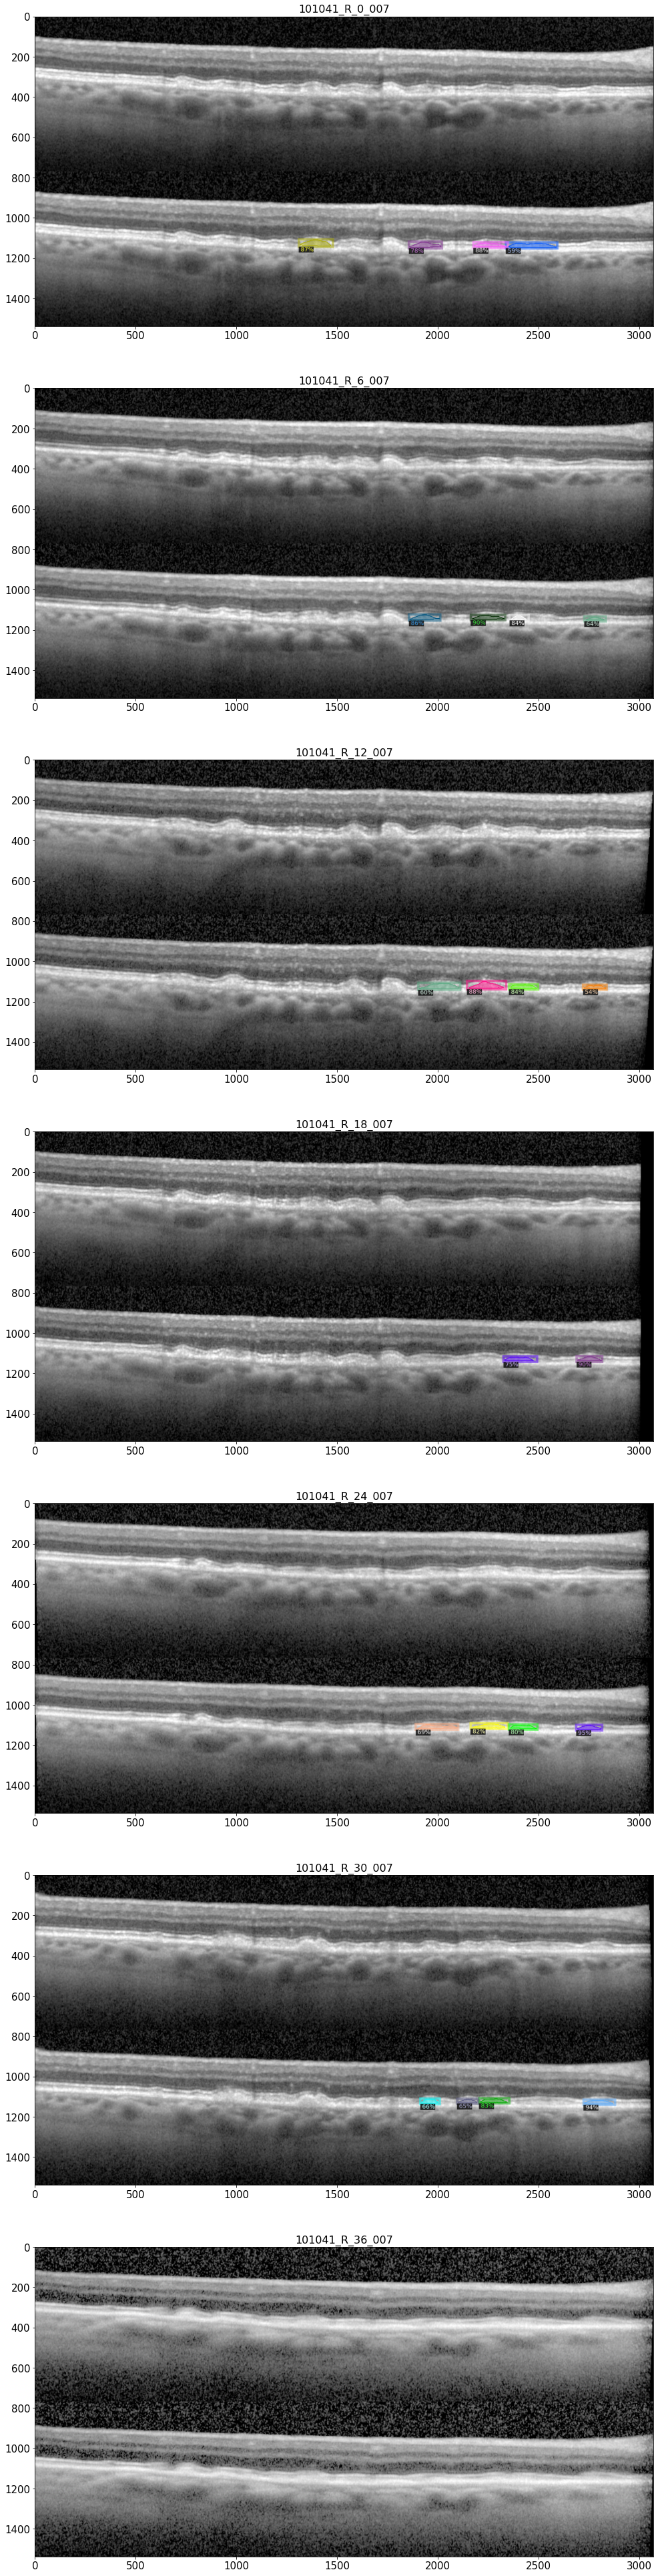

In [96]:
fig,axs = plt.subplots(7,1,figsize=[30,70])
# fig.delaxes(fig.axes[-2])
# fig.delaxes(fig.axes[-1])
for ax,imgid in zip(fig.axes,imgids):
    im,im_pred = vis.get_image(imgid)
    hcrange = list(vis.height_crop_range(np.array(im.convert('L')),height_target=256*vis.scale))
    imarr = np.concatenate((np.array(im)[hcrange,:],np.array(im_pred)[hcrange,:]),axis=0)
    ax.imshow(imarr)
    ax.set_title(imgid)

In [97]:
plt.tight_layout()
fig.savefig(f'output_dfCERA_long/{ptid}_{eye}_scan{scan}.png',dpi=120)

<Figure size 432x288 with 0 Axes>

## Image histogram correlations

Rule out or establish correlation with image histogram

In [17]:
import cv2
mu_dict = {}
bins = np.arange(0,256)
for volid in eye_groups.get_group((ptid,eye)).volID.values:
    imgids = [f'{volid}_{s:03d}' for s in range(0,18)]
    mu = np.empty((len(imgids),496,1024))
    for i,imgid in enumerate(imgids):       
        dat = vis.get_gt_image_data(imgid)
        im = cv2.imread(dat['file_name'],cv2.IMREAD_GRAYSCALE)
        mu[i] = im

    mu_dict[volid] = np.histogram(mu.flatten(),bins=bins)

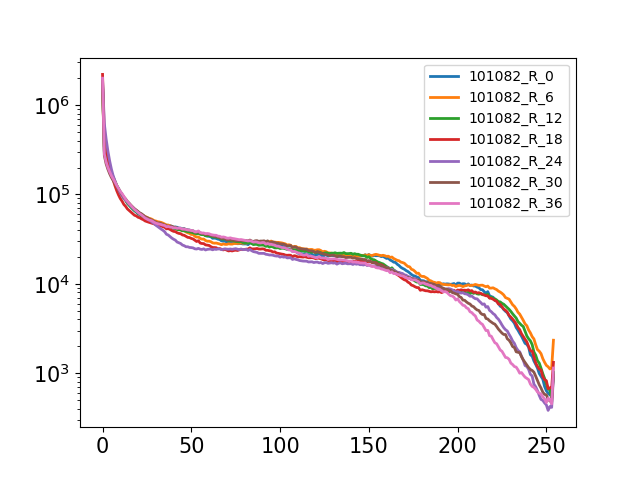

In [18]:
%matplotlib widget
for k,(h,b) in mu_dict.items():
    plt.plot(b[:-1],h,label=k)
plt.yscale('log')
plt.legend()
